In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import warnings
warnings.filterwarnings('ignore')

In [2]:
headers = {
  'Referer': 'https://stats.nba.com/players/shots-dribbles',
  'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
  'x-nba-stats-origin': 'stats'
}

def seasons_string(start,end):
    '''
    creates a list of NBA seasons from start-end
    '''
    years = np.arange(start,end+1)
    seasons = []
    for year in years:
        string1 = str(year)
        string2 = str(year+1)
        season = '{}-{}'.format(string1,string2[-2:])
        seasons.append(season)
    return seasons


def get_shooting_stats(url="http://stats.nba.com/stats/leaguedashplayerptshot?",PerMode="PerGame",LeagueID = "00",
                       Season = "2019-20",SeasonType = "Regular Season",PORound= 0,CloseDefDistRange= '',ShotClockRange='',
                       ShotDistRange= '',TouchTimeRange= '',DribbleRange= "0 Dribbles",GeneralRange= '',TeamID= 0,Outcome= '',
                       Location= '',Month= 0,SeasonSegment= '',DateFrom= '',DateTo= '',OpponentTeamID= 0,VsConference= '',
                       VsDivision= '',Conference= '',Division= '',GameSegment= '',Period= 0,LastNGames= 0):
    api_param = locals()
    payload = {}
    response = requests.request("GET",url,params=api_param,headers=headers,data = payload)
    data = response.json()
    df = pd.DataFrame(data['resultSets'][0]['rowSet'],columns=data['resultSets'][0]['headers'])
    df["Season"] = Season
    df["CloseDefDistRange"] = CloseDefDistRange
    df["DribbleRange"] = DribbleRange
    return df

def get_usg_stats(url="http://stats.nba.com/stats/leaguedashplayerstats?",MeasureType= "Advanced",PerMode= "PerGame",
                  PlusMinus= "N",PaceAdjust= "N",Rank= "N",LeagueID= "00",Season= "2019-20",SeasonType= "Regular Season",
                  PORound= 0,Outcome= '',Location= '',Month= 0,SeasonSegment= '',DateFrom= '',DateTo= '',OpponentTeamID= 0,
                  VsConference= '',VsDivision= '',TeamID= 0,Conference= '',Division= '',GameSegment= '',Period= 0,
                  ShotClockRange= '',LastNGames= 0,GameScope= '',PlayerExperience= '',PlayerPosition= '',StarterBench= '',
                  DraftYear= '',DraftPick= '',College= '',Country= '',Height= '',Weight= '',TwoWay= 0):
    url = url
    api_param = locals()
    payload = {}
    response = requests.request("GET",url,params=api_param,headers=headers,data = payload)
    data = response.json()
    df = pd.DataFrame(data['resultSets'][0]['rowSet'],columns=data['resultSets'][0]['headers'])
    df["Season"] = Season
    return df

In [110]:
start_season = 2017
end_season = 2019
def load_usg():
    usg_stats_df = []
    for season in seasons_string(start_season,end_season):
        usg_stats_df.append(get_usg_stats(Season=season))
    usg_stats_df = pd.concat([x for x in usg_stats_df],ignore_index=True)
    return usg_stats_df
    
def load_defense():
    def_df = pd.read_csv("rapm.csv").drop_duplicates()
    return def_df

def load_shooting():
    dribbles = ["0 Dribbles","1 Dribble","2 Dribbles","3-6 Dribbles","7+ Dribbles"]
    CloseDefDistRanges = ['0-2 Feet - Very Tight','2-4 Feet - Tight','4-6 Feet - Open','6+ Feet - Wide Open']
    shooting_stats_df = []
    for season in seasons_string(start_season,end_season):
        for dribble in dribbles:
            for closeDefDistRange in CloseDefDistRanges:
                shooting_stats_df.append(get_shooting_stats(Season=season,CloseDefDistRange=closeDefDistRange,DribbleRange=dribble))
    shooting_stats_df = pd.concat([x for x in shooting_stats_df],ignore_index=True)
    return shooting_stats_df
    
def load_data():
    return load_usg(),load_defense(),load_shooting()

In [232]:
def active_players_only_filter(df):
    last_season_played = df.groupby("PLAYER_NAME",as_index=False).max()
    last_season_played = last_season_played[last_season_played["Season"] == "2019-20"][["PLAYER_NAME"]]
    return df.merge(last_season_played,left_on="PLAYER_NAME",right_on="PLAYER_NAME")
    

In [989]:
def pre_proccessing_shots(shots_df):
    shots_df["TOTAL_ATTEMPTS"] = round(shots_df["GP"] * shots_df["FG3A"])
    shots_df["TOTAL_MADE"]     = round(shots_df["GP"] * shots_df["FG3M"])   
    shots_df["FGA_ATTEMPTS"] =   round(shots_df["GP"] * shots_df["FGA"])
    shots_df["FREQ_PCT"]       = shots_df.groupby('PLAYER_NAME')["TOTAL_ATTEMPTS"].transform(np.sum) / shots_df.groupby('PLAYER_NAME')["FGA_ATTEMPTS"].transform(np.sum)
    shots_df["SUM_ATTEMPTS"] = shots_df.groupby(['PLAYER_NAME'],as_index=False)["TOTAL_ATTEMPTS"].transform("sum")
    return shots_df

def group_shooting_data(shots_df):
    wide_open_shot_weight = 1.53
    open_shot_weight = 1
    shots_df = shots_df.groupby(['PLAYER_NAME','CloseDefDistRange'],as_index=False).agg({'FREQ_PCT':'max','SUM_ATTEMPTS':'max','TOTAL_ATTEMPTS':'sum','TOTAL_MADE':'sum'})
    shots_df["PCT"] = shots_df["TOTAL_MADE"] /  shots_df["TOTAL_ATTEMPTS"]
    shots_df.loc[shots_df.CloseDefDistRange=="6+ Feet - Wide Open", 'PCT'] =\
    shots_df.loc[shots_df.CloseDefDistRange=="6+ Feet - Wide Open", 'PCT'] * wide_open_shot_weight
    shots_df = shots_df.groupby(['PLAYER_NAME'],as_index=False).agg({'FREQ_PCT':'max','SUM_ATTEMPTS':'max','TOTAL_ATTEMPTS':'sum','TOTAL_MADE':'sum','PCT':'sum'})
    shots_df["NORMALIZED_PCT"] = shots_df["PCT"] / (wide_open_shot_weight + open_shot_weight)
    shots_df = shots_df.drop("PCT",axis=1)
    return shots_df

def filter_relevant_shot_types(shots_df):
    dribbles = ["0 Dribbles"]
    CloseDefDistRanges = ['4-6 Feet - Open','6+ Feet - Wide Open']
    return shots_df[(shots_df["DribbleRange"].isin(dribbles)) & (shots_df["CloseDefDistRange"].isin(CloseDefDistRanges))]

def filter_shooting_data(shots_df,freq_pct):
    min_attempts = 120#200
    shots_df = shots_df[shots_df["SUM_ATTEMPTS"] > min_attempts]
    shots_df = shots_df[shots_df["FREQ_PCT"] > freq_pct]
    return shots_df

def calculate_shot_avg(shot_df):
    return shot_df['TOTAL_MADE'].sum() / shot_df['TOTAL_ATTEMPTS'].sum()

In [998]:
def pre_proccessing_usg(usg_df):
    usg_df["TOTAL_USG"] = (usg_df["USG_PCT"] * usg_df["GP"] * usg_df["MIN"])
    usg_df["TOTAL_AST"] = (usg_df["AST_PCT"] * usg_df["GP"] * usg_df["MIN"])
    usg_df["TOTAL_MIN"] = (usg_df["GP"] * usg_df["MIN"])
    return usg_df

def filter_usg_data(usg_df,max_usg , min_minuites):
    usg_df = usg_df[usg_df["TOTAL_MIN"] > min_minuites]
    max_ast = usg_df["TOTAL_AST"].mean()
    usg_df = usg_df[usg_df["TOTAL_USG"] < max_usg]
    usg_df = usg_df[usg_df["TOTAL_AST"] < max_ast]
    return usg_df

def group_usg_data(usg_df):
    usg_df = usg_df.groupby(['PLAYER_NAME'],as_index=False).agg({'TOTAL_USG':'sum','TOTAL_AST':'sum',"TOTAL_MIN":'sum'})
    usg_df["TOTAL_USG"] /= usg_df["TOTAL_MIN"]
    usg_df["TOTAL_AST"] /= usg_df["TOTAL_MIN"]
    return usg_df



In [351]:
from matplotlib.patches import Rectangle
def draw_graph(avg_shot_pct):
    
    blakclist = ["Ben McLemore",
                "Wayne Ellington",
                "DeMarre Carroll",
                "Timothe Luwawu-Cabarrot",
                "Trevor Ariza",
                "Dragan Bender"]
    
    alpha= 0.2
    min_drpm = -3
    max_drpm =3.5
    min_shot_pct = 0.25
    max_shot_pct = 0.5
    avg_shooting_pct = avg_shot_pct
    avg_rapm = def_df["RAPM__Def"].mean()
    d_and_3_df[~d_and_3_df.isin(blakclist)]

    ax = d_and_3_df.plot.scatter(x="NORMALIZED_PCT",y="RAPM__Def",figsize=(20,15))
    ax.add_patch(Rectangle((min_shot_pct,min_drpm), avg_shooting_pct - min_shot_pct , abs(avg_rapm - min_drpm),color='red',alpha=alpha))
    ax.add_patch(Rectangle((min_shot_pct,avg_rapm), avg_shooting_pct - min_shot_pct , abs(max_drpm - avg_rapm),color='yellow',alpha=alpha))
    ax.add_patch(Rectangle((avg_shooting_pct,min_drpm), max_shot_pct - avg_shooting_pct , abs(avg_rapm - min_drpm),color='yellow',alpha=alpha))
    ax.add_patch(Rectangle((avg_shooting_pct,avg_rapm), max_shot_pct - avg_shooting_pct , abs(max_drpm - avg_rapm),color='green',alpha=alpha))
    ax.set_ylim(-3,3.2)
    for i, txt in enumerate(d_and_3_df.PLAYER_NAME):
        last_name_cnt = d_and_3_df[d_and_3_df["PLAYER_NAME"].str.contains(" " + txt.split(" ")[1])].count()["primaryKey"]

        if(last_name_cnt > 1): # take first name and last name
            name = txt.split(" ")[0][0] + "." + txt.split(" ")[1]
        else: # take last name
            name = txt.split(" ")[0][0] + "." + txt.split(" ")[1]#txt.split(" ")[1]

        ax.annotate( name, (d_and_3_df["NORMALIZED_PCT"].iat[i],d_and_3_df["RAPM__Def"].iat[i]),\
                    xytext=(d_and_3_df["NORMALIZED_PCT"].iat[i],d_and_3_df["RAPM__Def"].iat[i]), textcoords='data',rotation=0)

    plt.show()

In [561]:
shooting_df = load_shooting()
shooting_df = active_players_only_filter(shooting_df)

In [1015]:
shooting_df_v2 = pre_proccessing_shots(shooting_df)
shooting_df_v2 = filter_relevant_shot_types(shooting_df_v2)
avg_shot_pct = calculate_shot_avg(shooting_df_v2)
shooting_df_v2 = filter_shooting_data(shooting_df_v2,0.45)
shooting_df_v2 = group_shooting_data(shooting_df_v2)


,DRIBBLE_DIST,PCT_ATTEMPTS
0,"0-2 Feet - Very Tight,0 Dribbles",0.456911
1,"0-2 Feet - Very Tight,1 Dribble",0.176101
2,"0-2 Feet - Very Tight,2 Dribbles",0.060287
3,"0-2 Feet - Very Tight,3-6 Dribbles",0.079325
4,"0-2 Feet - Very Tight,7+ Dribbles",0.025384
5,"2-4 Feet - Tight,0 Dribbles",8.051466
6,"2-4 Feet - Tight,1 Dribble",2.146529
7,"2-4 Feet - Tight,2 Dribbles",0.653636
8,"2-4 Feet - Tight,3-6 Dribbles",0.740894
9,"2-4 Feet - Tight,7+ Dribbles",0.220523


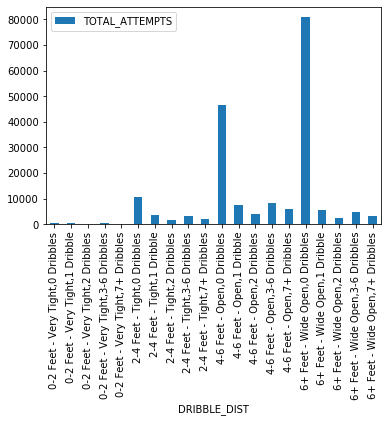

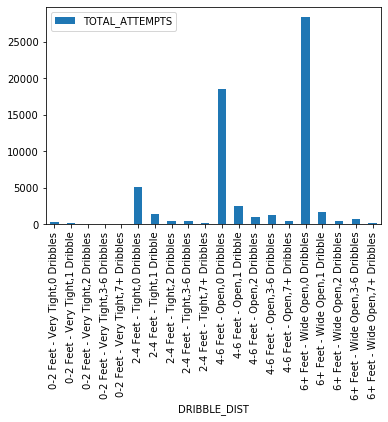

In [999]:
shooting_df_attempts_dist_range = pre_proccessing_shots(shooting_df)
shooting_df_attempts_dist_range["DRIBBLE_DIST"] = shooting_df_attempts_dist_range["CloseDefDistRange"] + "," + shooting_df_attempts_dist_range["DribbleRange"]
shooting_df_attempts_dist_range.groupby("DRIBBLE_DIST",as_index=False).sum().plot.bar(x="DRIBBLE_DIST",y="TOTAL_ATTEMPTS")

shooting_df_attempts_dist_range = pre_proccessing_shots(filter_shooting_data(shooting_df,0.45))
shooting_df_attempts_dist_range = shooting_df_attempts_dist_range.merge(filter_usg_data(group_usg_data(pre_proccessing_usg(usg_df)),0.25,600))
shooting_df_attempts_dist_range["DRIBBLE_DIST"] = shooting_df_attempts_dist_range["CloseDefDistRange"] + "," + shooting_df_attempts_dist_range["DribbleRange"]
shooting_df_attempts_dist_range.groupby("DRIBBLE_DIST",as_index=False).sum().plot.bar(x="DRIBBLE_DIST",y="TOTAL_ATTEMPTS")

attempts_df = shooting_df_attempts_dist_range.groupby("DRIBBLE_DIST",as_index=False)["TOTAL_ATTEMPTS"].sum()
attempts_df["PCT_ATTEMPTS"] = (attempts_df["TOTAL_ATTEMPTS"] / attempts_df["TOTAL_ATTEMPTS"].sum()) * 100
attempts_df[["DRIBBLE_DIST","PCT_ATTEMPTS"]]

In [ ]:
usg_df = load_usg()
usg_df = active_players_only_filter(usg_df)

In [1073]:
usg_df_v2 = usg_df.copy()
usg_df_v2 = pre_proccessing_usg(usg_df_v2)
usg_df_v2 = group_usg_data(usg_df_v2)
usg_df_v2 = filter_usg_data(usg_df_v2,0.25,600)

In [1074]:
shooting_usg_df = shooting_df_v2.merge(usg_df_v2)
shooting_usg_df[["PLAYER_NAME","FREQ_PCT","NORMALIZED_PCT"]].head(10)

,PLAYER_NAME,FREQ_PCT,NORMALIZED_PCT
0,Abdel Nader,0.468421,0.335602
1,Al-Farouq Aminu,0.527464,0.354603
2,Allen Crabbe,0.669683,0.403438
3,Anthony Tolliver,0.796785,0.423556
4,Austin Rivers,0.524684,0.365035
5,Ben McLemore,0.661417,0.401544
6,Brook Lopez,0.527698,0.325255
7,Bruno Caboclo,0.527108,0.313890
8,Bryn Forbes,0.550489,0.424268
9,Buddy Hield,0.504409,0.457208


In [1075]:
def_df = load_defense()

In [1076]:
d_and_3_df = shooting_usg_df.merge(def_df,on="PLAYER_NAME")
d_and_3_df = d_and_3_df.sort_values("RAPM__Def")

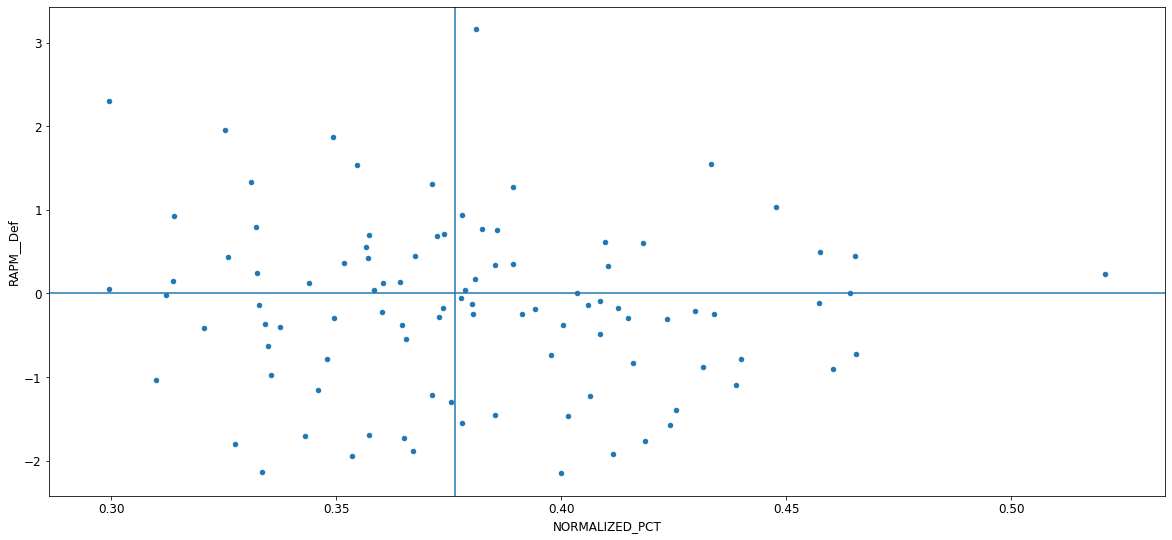

In [1089]:
avg_shooting_pct = avg_shot_pct
avg_rapm = def_df["RAPM__Def"].mean()
ax = d_and_3_df.plot.scatter(x="NORMALIZED_PCT",y="RAPM__Def",figsize=(20,9))
plt.axvline(avg_shooting_pct)
plt.axhline(avg_rapm)
plt.show()

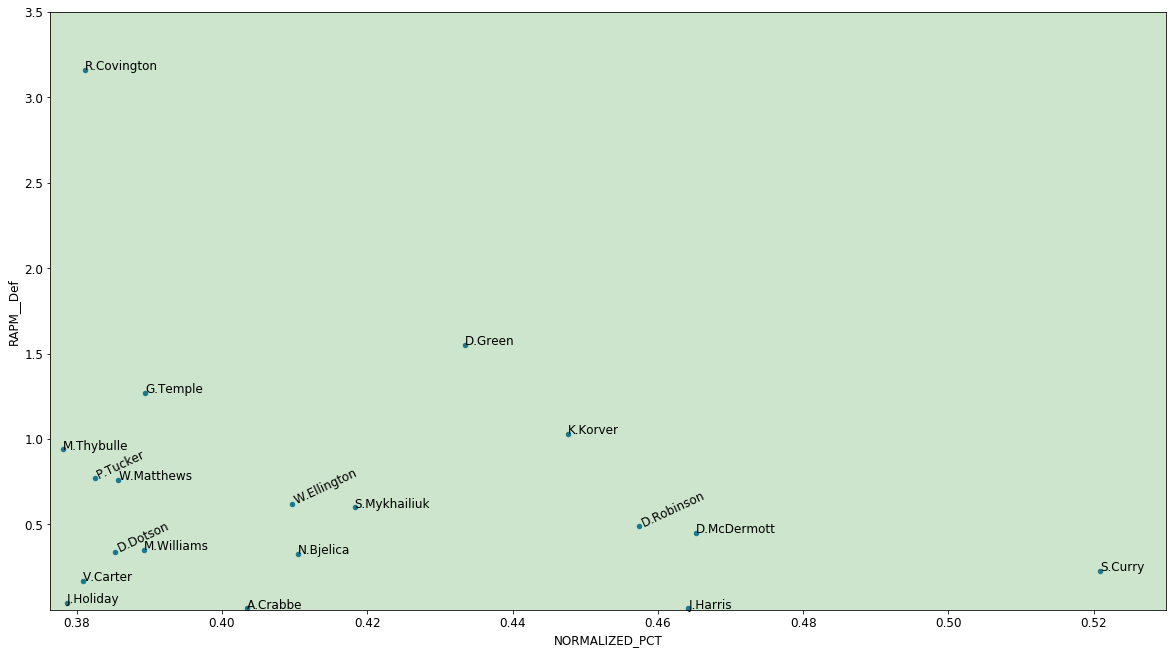

In [1090]:
d_and_3_df_best = d_and_3_df[d_and_3_df["RAPM__Def"] > avg_rapm]
d_and_3_df_best = d_and_3_df_best[d_and_3_df_best["NORMALIZED_PCT"] > avg_shooting_pct]     
    
alpha= 0.2
min_drpm = -3
max_drpm =3.5
min_shot_pct = 0.25
max_shot_pct = 0.53
avg_shooting_pct = avg_shot_pct
avg_rapm = def_df["RAPM__Def"].mean()
ax = d_and_3_df_best.plot.scatter(x="NORMALIZED_PCT",y="RAPM__Def",figsize=(20,11))
ax.add_patch(Rectangle((min_shot_pct,min_drpm), avg_shooting_pct - min_shot_pct , abs(avg_rapm - min_drpm),color='red',alpha=alpha))
ax.add_patch(Rectangle((min_shot_pct,avg_rapm), avg_shooting_pct - min_shot_pct , abs(max_drpm - avg_rapm),color='yellow',alpha=alpha))
ax.add_patch(Rectangle((avg_shooting_pct,min_drpm), max_shot_pct - avg_shooting_pct , abs(avg_rapm - min_drpm),color='yellow',alpha=alpha))
ax.add_patch(Rectangle((avg_shooting_pct,avg_rapm), max_shot_pct - avg_shooting_pct , abs(max_drpm - avg_rapm),color='green',alpha=alpha))
ax.set_ylim(avg_rapm,max_drpm,2)
ax.set_xlim(avg_shooting_pct,max_shot_pct,2)

for i, txt in enumerate(d_and_3_df_best.PLAYER_NAME):
    last_name_cnt = d_and_3_df_best[d_and_3_df_best["PLAYER_NAME"].str.contains(" " + txt.split(" ")[1])].count()["primaryKey"]
    rotation = 0
    if txt in (["Eric Gordon","Damyean Dotson","Ryan Broekhoff","P.J. Tucker","Jared Dudley","Wayne Ellington","Duncan Robinson"]):
        rotation = 25
    
    if(last_name_cnt > 1): # take first name and last name
        name = txt.split(" ")[0][0] + "." + txt.split(" ")[1]
    else: # take last name
        name = txt.split(" ")[0][0] + "." + txt.split(" ")[1]#txt.split(" ")[1]
    ax.annotate( name, (d_and_3_df_best["NORMALIZED_PCT"].iat[i],d_and_3_df_best["RAPM__Def"].iat[i]),\
                xytext=(d_and_3_df_best["NORMALIZED_PCT"].iat[i],d_and_3_df_best["RAPM__Def"].iat[i]), textcoords='data',rotation=rotation)
plt.show()

In [1079]:
d_and_3_df_ranking = d_and_3_df
d_and_3_df_ranking["DRAPM"] = d_and_3_df_ranking["RAPM__Def"]
d_and_3_df_ranking["DRAPM_RANK"] = d_and_3_df_ranking["RAPM__Def"].rank(method='first',ascending=False)
d_and_3_df_ranking["3PT_RANK"] = d_and_3_df_ranking["NORMALIZED_PCT"].rank(method='first',ascending=False)
d_and_3_df_ranking["TOTAL_RANK"] = (d_and_3_df_ranking["DRAPM_RANK"] + d_and_3_df_ranking["3PT_RANK"])/2
d_and_3_df_ranking = d_and_3_df_ranking[["PLAYER_NAME","DRAPM",'NORMALIZED_PCT',"FREQ_PCT","DRAPM_RANK","3PT_RANK","TOTAL_RANK"]]

In [1080]:
d_and_3_df_ranking_best = d_and_3_df_ranking[d_and_3_df_ranking["DRAPM"] > avg_rapm]
d_and_3_df_ranking_best = d_and_3_df_ranking_best[d_and_3_df_ranking_best["NORMALIZED_PCT"] > avg_shooting_pct]

In [1082]:
d_and_3_df_ranking_best.sort_values("TOTAL_RANK").head(60)

,PLAYER_NAME,DRAPM,NORMALIZED_PCT,FREQ_PCT,DRAPM_RANK,3PT_RANK,TOTAL_RANK
18,Danny Green,1.55,0.433393,0.658537,5.0,12.0,8.5
50,Kyle Korver,1.03,0.447668,0.759866,10.0,8.0,9.0
25,Doug McDermott,0.45,0.465245,0.490253,24.0,3.0,13.5
27,Duncan Robinson,0.49,0.457432,0.874028,22.0,6.0,14.0
77,Seth Curry,0.23,0.520867,0.549485,32.0,1.0,16.5
81,Svi Mykhailiuk,0.60,0.418243,0.690741,20.0,19.0,19.5
95,Wayne Ellington,0.62,0.409641,0.829511,19.0,25.0,22.0
72,Robert Covington,3.16,0.381114,0.660356,1.0,43.0,22.0
41,Joe Harris,0.01,0.464190,0.546085,42.0,4.0,23.0
30,Garrett Temple,1.27,0.389407,0.563859,9.0,37.0,23.0


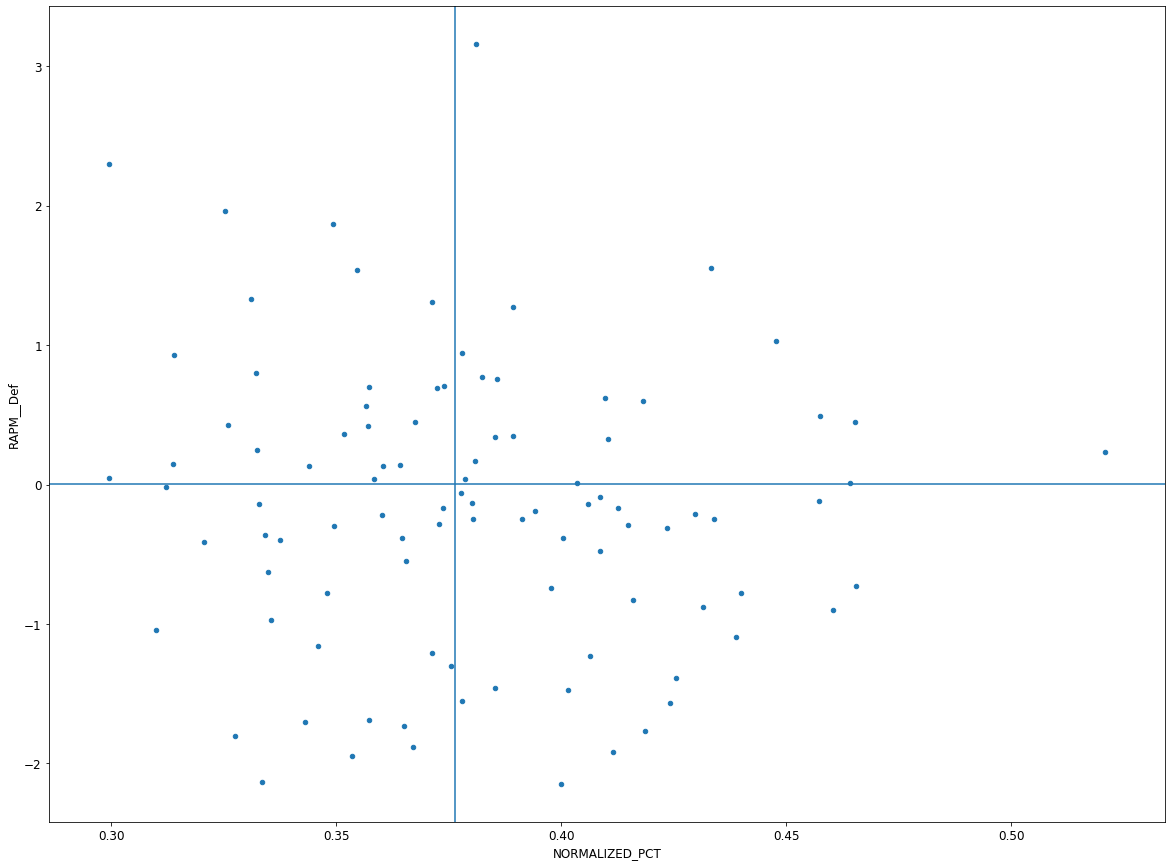